<div style="background-color:	#345783; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Huisprijzen voorspellen</h1>
<b style="color:black"> Kaggle: Yoyoyoghurt(teamnaam), JortAkershoek, juliaboschman, Sam Keesen </b>
   
<b style="color:white"> Jort Akershoek, Julia Boschman, Sam Keesen</b>
    </div>

<a name='start'></a>

## Table of contents

1. [H1: Inleiding](#1.0)
2. [H2: EDA](#2.0)
    - [&sect;2.1: EDA DataFrame](#2.1)
    - [&sect;2.2: EDA Foto's](#2.2)
    - [&sect;2.3: Conclusie EDA](#2.3)
3. [H3: Fully-connected neuraal netwerk](#3.0)
    - [&sect;3.1: Het model](#3.1)
    - [&sect;3.2: Modelarchitectuur](#3.2)
    - [&sect;3.3: Keuzes voor het model](#3.3)
    - [&sect;3.4: Loss function en optimizer kiezen](#3.4)
    - [&sect;3.5: Het model compilen](#3.5)
    - [&sect;3.6: Visualisatie Loss](#3.6)
4. [H4: Convolutioneel neuraal netwerk](#4.0)
    - [&sect;4.1: Data preprocessing](#4.1)
    - [&sect;4.2: Hyperparameter tuner](#4.2)
    - [&sect;4.3: Het model](#4.3)
    - [&sect;4.4: Modelarchitectuur](#4.4)
    - [&sect;4.5: Het model trainen](#4.5)
    - [&sect;4.6: Keuze en onderbouwing hyperparameters](#4.6)
    - [&sect;4.7: Uitleg dropout en batch normalization](#4.7)
    - [&sect;4.8: Keuze en onderbouwing data pipeline](#4.8)
5. [H5: Transfer Learning](#5.0)
    - [&sect;5.1: Het model](#5.1)
    - [&sect;5.2: Modelarchitectuur](#5.2)
    - [&sect;5.3: Het model trainen](#5.3)
    - [&sect;5.4: Naam van de modelarchitectuur en de dataset](#5.4)
    - [&sect;5.5: Voordelen vooraf getrainde visionmodellen](#5.5)
    - [&sect;5.6: Stappen finetunen vooraf getraind model en motivatie keuzes](#5.6)
6. [H6: Multimodaal model](#6.0)
7. [H7: Bevindingen](#7.0)
    - [&sect;7.1: Samenvatting uitkomsten](#7.1)
8. [H8: Conclusie en aanbevelingen](#8.0)
    - [&sect;8.1: Uitdagingen modeleringsproces](#8.1)
    - [&sect;8.2: Prestaties modelarchitecturen](#8.2)
    - [&sect;8.3: Advies aan makelaar](#8.3)
    - [&sect;8.4: Advies aan huizen(ver)koper](#8.4)
9. [H9: Literatuurlijst](#9.0)

In [1]:
# Alle nodige imports
import os
import pydot
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from keras import regularizers
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


Om de modelarchitecturen te kunnen zien maken we gebruik van een library die nog geïnstalleerd moest worden op de laptops. Dat gebeurt hieronder, dus als deze library nog niet up jullie laptop staat kan het worden geïnstalleerd met de code hieronder. De cel weer daaronder verwijst naar de locatie waar de Graphviz in is gedownload. Als deze niet gedownload is op de laptop zal de plot ook niet gemaakt kunnen worden. Ook wordt efficientnet geinstalleerd wat later gebruikt wordt voor een transfer model.

In [3]:
#!pip install --user pydot graphviz
#!pip install --user efficientnet

In [4]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

[Back to the top](#start)
<a name='1.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Inleiding</strong></h2>
</div>

Voor het vak Deep Learning wordt er in dit portfolio onderzoek gedaan naar de werking en toepassing van verschillende vormen van neurale netwerken. De opdracht voor dit portfolio is het voorspellen van huisprijzen van huizen in Amerika met de hulp van neurale netwerken. Dit kunnen neurale netwerken zijn die alleen maar werken met tabulaire data, juist alleen met foto data of zelfs met beide. Er worden 4 verschillende neurale netwerken gebruikt in dit notebook en dat zijn als volgt:
- Fully-connected neuraal netwerk, alleen tabulaire data.
- Convolutioneel neuraal netwerk, alleen foto data.
- Transfer Learning, alleen foto data.
- Multimodaal model, zowel tabulaire als foto data.

Aan het einde van het notebook gaan wij reflecteren op de manier(en) die het beste resultaat heeft geleverd voor ons vraagstuk. Hier zal worden gekeken naar het model, maar ook wat de reden zou kunnen zijn dat het model beter werkt dan de andere.

[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: EDA</strong></h2>
</div>

<a name='2.1'></a>
<h3>&sect;2.1: EDA DataFrame</h3>

In [5]:
train = pd.read_csv("train.csv")
train.head()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


Als eerst gaan wij een EDA uitvoeren op de data die wij verkregen hebben voor dit project. Het gaat om twee verschillende soorten data. Er zijn zowel foto's als tabulaire data beschikbaar. Als eerst wordt er gekeken naar de tabulaire data.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


De kolommen bevatten het volgende:
- House ID: Het huis ID wat koppelt aan de ID's die aan de foto's verbonden zijn. Zo kan de target kolom toegevoegd worden aan de foto's.
- Bedrooms: Het aantal slaapkamers die er te vinden zijn in het huis.
- Bathrooms: Het aantal badkamers die er te vinden zijn in het huis.
- Area: Het totale oppervlakte wat hoort bij het huis.
- Latitude: De breedtegraad van het huis op de wereldkaart.
- Longitude: De hoogtegraad van het huis op de wereldkaart. Met deze en latitude wordt dus ook bepaald op welke locatie het huis zich bevindt.
- Price: Dit is de target kolom, de kolom die uiteindelijk voorspeld moet worden. Hierin staan de prijzen van de huizen.

In [7]:
train.isna().sum()

House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
Price        0
dtype: int64

In [8]:
train.describe()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


Het train DataFrame
1. Het is een Dataframe
2. Het heeft geen missende waardes
3. Alle kolommen zijn numeriek

In [9]:
test = pd.read_csv("test.csv")
test.head()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


Nadat er een kleine check is gedaan naar de inhoud van het "train" DataFrame wordt er een snelle check uitgevoerd op de test dataset. Dit wordt gedaan om te kijken of de data gebruikt kan worden om te testen. Zo mag het geen missende waardes bevatten en moet het overeenkomen met de train data zonder de "Price" kolom.

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


In [11]:
test.describe()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,518.000000,3.771429,2.600000,2297.171429,36.631043,-120.662114
std,10.246951,0.910259,0.591608,1457.127886,1.837672,1.670038
min,501.000000,2.000000,1.500000,987.000000,33.808500,-121.775800
25%,509.500000,3.000000,2.000000,1580.000000,34.724550,-121.775800
50%,518.000000,4.000000,2.500000,2012.000000,37.965800,-121.775800
75%,526.500000,4.000000,3.000000,2387.500000,37.965800,-119.311550
max,535.000000,7.000000,4.000000,9536.000000,37.965800,-117.922800


In [12]:
test.isna().sum()

House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
dtype: int64

Het test DataFrame
1. Het is een DataFrame
2. Het heeft geen missende waardes
3. Alle kolommen zijn numeriek

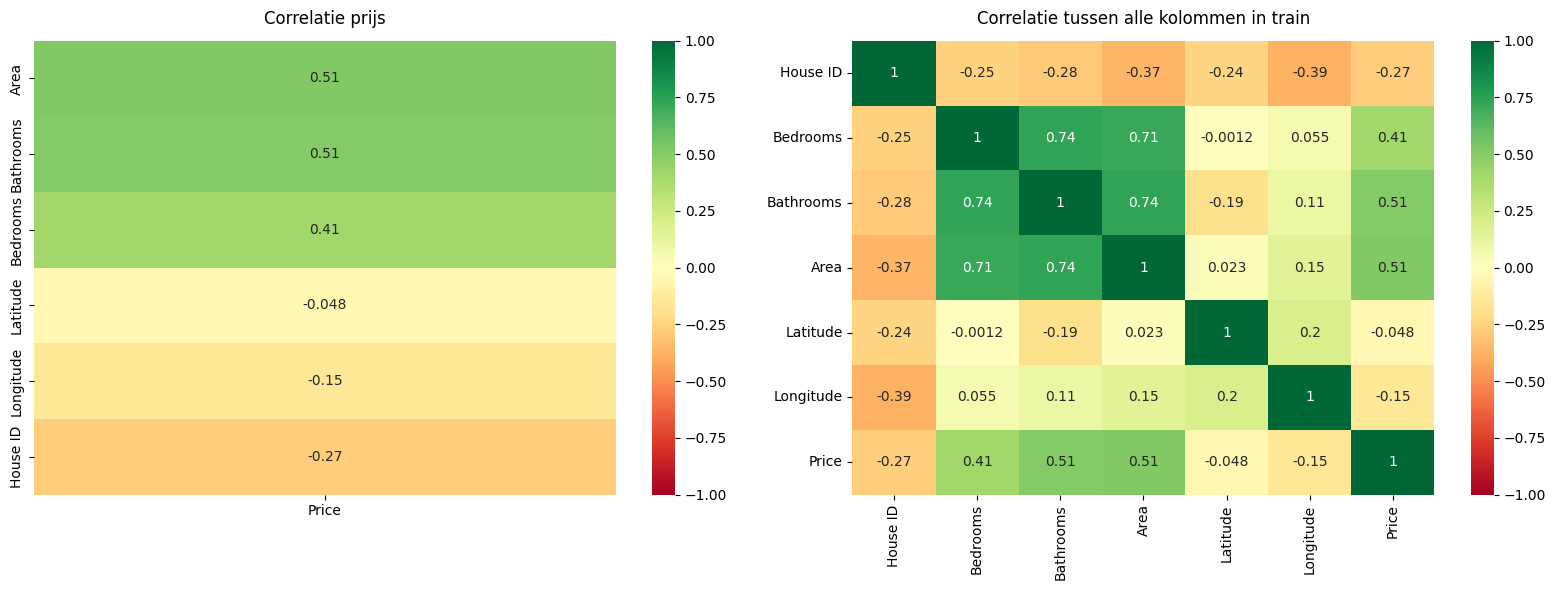

In [13]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(train.corr(method='pearson')[['Price']].drop("Price").sort_values(by='Price', ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie prijs', fontdict={'fontsize': 12}, pad=12)


plt.subplot(122) 
heatmap2 = sns.heatmap(train.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap2.set_title('Correlatie tussen alle kolommen in train', fontdict={'fontsize': 12}, pad=12)

plt.tight_layout()  
plt.show()

We zien in de heatmaps hierboven dat er een aantal kolommen zijn die wat meer invloed hebben op het voorspellen van de huisprijzen. Zo hebben de kolom "Area", "Bathrooms" en "Bedrooms" de meeste invloed. Ook zien we dat er een hoge correlatie is tussen de kolommen "Bathrooms" en "Bedrooms" en tussen de kolommen "Area" en "Bedrooms". Dit zijn voor ons dus belangrijke kolommen om te gebruiken voor ons latere Deep Learning model.

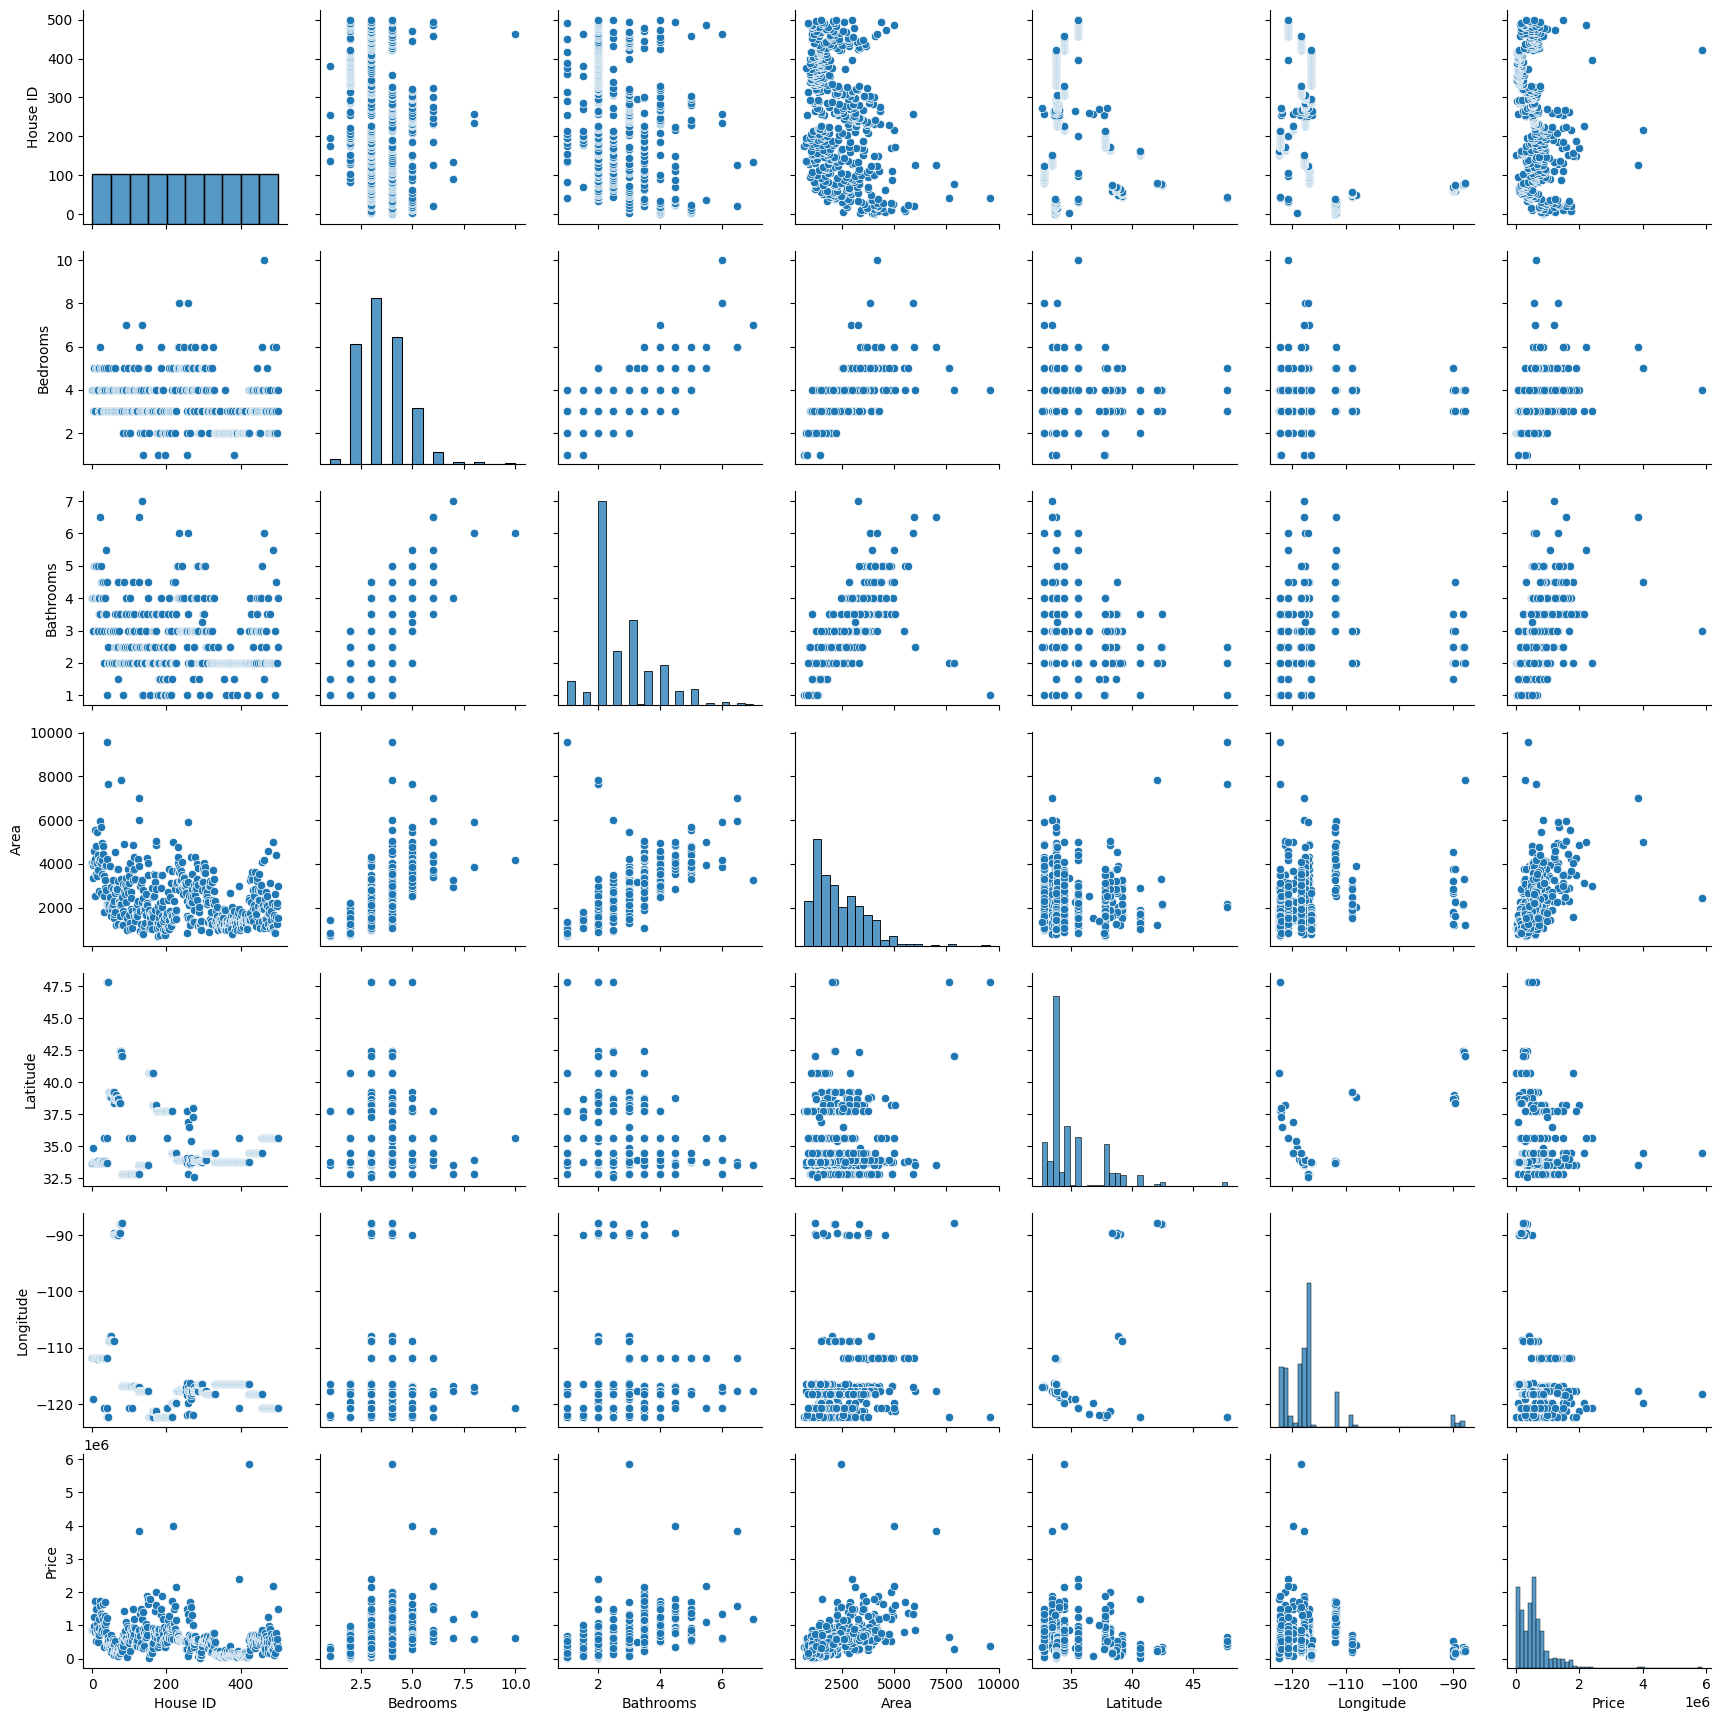

In [14]:
sns.pairplot(train)
plt.show()

Hierboven geven we een visualisatie van de correlaties tussen alle individuele kolommen. Hier zien wij weer de sterkste correlatie terug tussen de drie kolommen "Area", "Bedrooms" en "Bathrooms".

We gaan nu wat dieper kijken naar een aantal kolommen om te kijken naar mogelijke uitschieters.

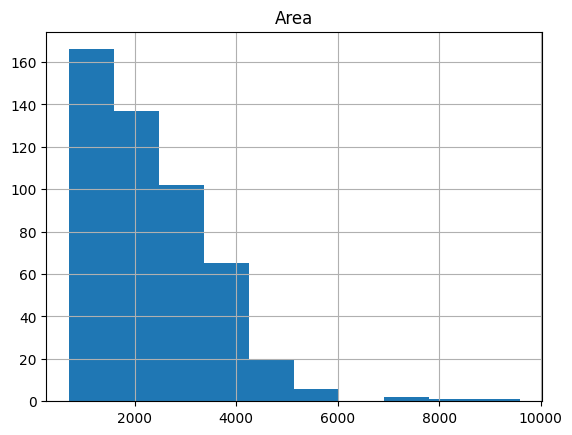

In [15]:
train.hist("Area")
plt.show()

We zien enkele uitschieters wanneer wij kijken naar de "Area" kolom. Wanneer wij de regels weergeven van de huizen met een oppervlakte van hoger dan 6000 vinden wij 4 huizen. Wij zien hier dat het grootste huis helemaal niet duur is. Het huis is nog net geen 4 ton, maar heeft wel een oppervlakte van bijna 10.000 square feet.

In [16]:
train[train["Area"] > 6000]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
40,41,4,1.0,9583,47.7918,-122.2243,395000
41,42,5,2.0,7627,47.7918,-122.2243,638940
78,79,4,2.0,7841,42.0467,-87.8859,299000
125,126,6,6.5,7000,33.5145,-117.7084,3850000


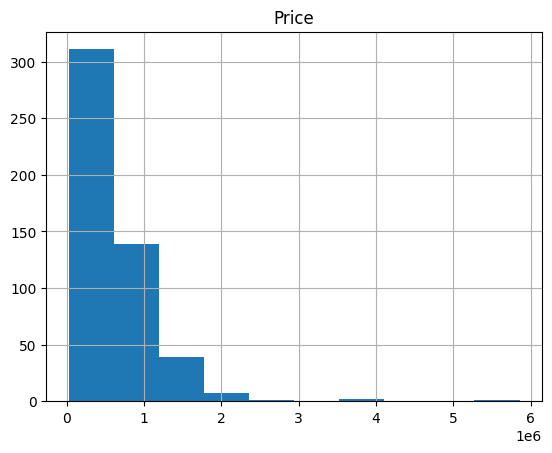

In [17]:
train.hist("Price")
plt.show()

Ook vinden wij een paar hoge uitschieters bij de "Price" kolom. Wanneer wij gaan kijken naar de rijen die hierbij horen valt het op dat het huis met de hoogste prijs van bijna 6 miljoen helemaal niet zo'n groot oppervlakte heeft. Dit valt op, vooral omdat wij net hebben gezien dat het grootste huis die 4 keer kleiner is wel 15 keer duurder is. Het zou te maken kunnen hebben met de ligging, dus dat gaan wij later verder onderzoeken.

In [18]:
train[train["Price"] > 3000000]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
125,126,6,6.5,7000,33.5145,-117.7084,3850000
216,217,5,4.5,5000,34.4453,-119.8025,4000000
421,422,4,3.0,2454,34.4835,-118.1959,5858000


Ook nemen wij een kijkje naar de huizen die meer dan 6 slaapkamers hebben. Dit zijn er maar een aantal en de oppervlaktes liggen dicht bij elkaar. Wat wel opvalt is de prijzen die erg uiteen liggen.

In [19]:
train[train["Bedrooms"] > 6]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
89,90,7,4.0,2929,32.8282,-116.7543,625000
133,134,7,7.0,3265,33.5145,-117.7084,1200000
234,235,8,6.0,3849,33.9208,-117.6096,580000
256,257,8,6.0,5900,32.8562,-116.9201,1350000
461,462,10,6.0,4188,35.6406,-120.7003,629000


Aan het begin van onze EDA hebben wij gezien dat er een aantal kolommen het meeste invloed hebben op het voorspellen van de huisprijs. Deze gaan wij wat beter bekijken door naar de groepsgemiddeldes te kijken.

In [20]:
bedrooms = train.groupby("Bedrooms")[["Price", "Area"]].mean()
bedrooms

,Price,Area
Bedrooms,,
1,2.828180e+05,909.400000
2,2.326775e+05,1303.196721
3,5.980077e+05,2045.183432
4,7.887358e+05,2970.038760
5,8.186575e+05,3775.263158
6,1.180959e+06,4399.538462
7,9.125000e+05,3097.000000
8,9.650000e+05,4874.500000
10,6.290000e+05,4188.000000


Het valt ons op dat de oppervlaktes van de huizen veelal toenemen hoe meer slaapkamers er aanwezig zijn. Bij de prijs is dit een ander geval. Wij zien het geleidelijk toenemen tot hij zijn maximum heeft bereikt bij 6 slaapkamers. Hier telt hij een gemiddelde prijs van wel 1 miljoen. Hierna neemt het weer af.

In [21]:
train["Bedrooms"].value_counts()

Bedrooms
3     169
4     129
2     122
5      57
6      13
1       5
7       2
8       2
10      1
Name: count, dtype: int64

Wanneer wij kijken naar de aantallen die voorkomen met meer dan 6 slaapkamers zien wij dat er aan veel kleiner aantal aan huizen is. Daarom is het niet betrouwbaar om deze te serieus te nemen tijdens het voorspellen van de prijs, omdat er bijvoorbeeld 1 huis is met 10 slaapkamers en 0 huizen met 9 slaapkamers.

In [22]:
bathrooms = train.groupby("Bathrooms")[["Price", "Area"]].mean()
bathrooms

,Price,Area
Bathrooms,,
1.00,3.608495e+05,1323.750000
1.50,5.223000e+05,1346.846154
2.00,3.371919e+05,1640.338164
2.50,6.214254e+05,2286.727273
3.00,6.996374e+05,2770.383721
3.25,5.150000e+05,3149.000000
3.50,1.066022e+06,3284.771429
4.00,8.905609e+05,3619.170732
4.50,1.367707e+06,4168.857143


Wij doen het zelfde voor de "Bathroom" kolom. Hierin stijgt ook de oppervlaktes van de huizen na mate er meer badkamers aanwezig zijn. De prijs is echter redelijk instabiel. Ook is het gemiddelde niet heel betrouwbaar, omdat de data niet goed verdeeld is. Zo zijn er 207 huizen met 2 badkamers en maar 3 huizen met 6 badkamers. Dit is waarschijnlijk dan ook het geval dat er niet veel huizen zijn met zo veel badkamers.

In [23]:
train["Bathrooms"].value_counts()

Bathrooms
2.00    207
3.00     86
2.50     55
4.00     41
3.50     35
1.00     24
5.00     16
4.50     14
1.50     13
6.00      3
6.50      2
5.50      2
7.00      1
3.25      1
Name: count, dtype: int64

Het valt ons op dat er ook halve waardes zijn voor de kolom "Bathrooms". Wij gaan er van uit dat dit badkamers zijn waar alleen een WC aanwezig is.

<a name='2.2'></a>
<h3>&sect;2.2: EDA Foto's</h3>

In [24]:
img_directory = "Train"
image_size = (1024, 1024)
batch_size = 4

image_dataset = tf.keras.utils.image_dataset_from_directory(
    img_directory,
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size
)

image_file_paths = image_dataset.file_paths
image_hids = [Path(image_file_path).stem for image_file_path in image_file_paths]
image_hids_int = [int(house_id) for house_id in image_hids]

tabular_data = train.loc[train['House ID'].isin(image_hids_int)].drop(columns=['House ID', 'Price'])

tabular_dataset = tf.data.Dataset.from_tensor_slices(tabular_data).batch(batch_size)

labels = [train.loc[train['House ID'] == houseid, 'Price'].values for houseid in image_hids_int]
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)
final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))
combined_dataset = tf.data.Dataset.zip((final_dataset, tabular_dataset))

Found 500 files belonging to 1 classes.


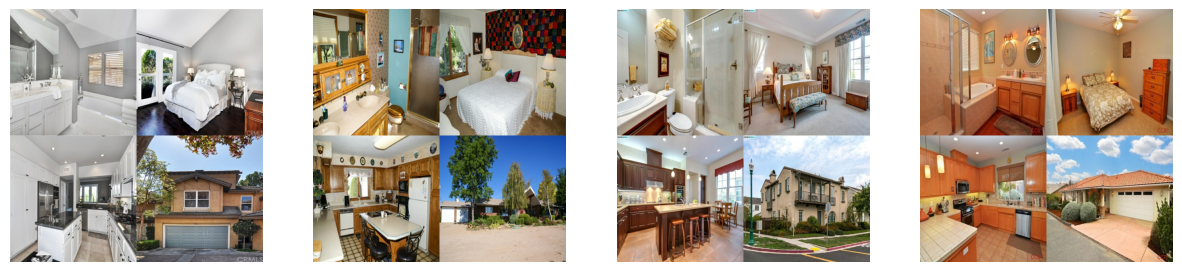

In [25]:
image_iterator = iter(image_dataset)
batch_images = next(image_iterator)

num_images_to_display = 4

plt.figure(figsize=(15, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

<a name='2.3'></a>
<h3>&sect;2.3: Conclusie EDA</h3>

Na het uitvoeren van de EDA wordt het duidelijk dat het een lastige opdracht gaat worden. Van een heleboel huizen blijkt dat er uitschieters aanwezig zijn. Zo zijn er veel grote huizen die niet heel duur zijn of hele kleine huizen die wel erg duur zijn. Alle gegevens geven niet meteen een goede indicatie van de prijs die gekoppeld is aan het huis. 

Wel weten we nu van een aantal kolommen dat ze belangrijk zijn. Zo is de Area kolom en de Bathroom kolom het meeste waarde toevoegen aan het voorspellen van de prijs. Bij beide kolommen zagen we in de grafieken een positieve correlatie. 

Nu moeten er heel wat modellen getraind worden om op goede resultaten uit te komen. Zoals eerder vermeld zijn er wel een hoop uitschieters in de data waardoor er een kans is dat de modellen nooit heel goed gaan worden. Er zijn vaak meer redenen waarom een woning een bepaalde prijs heeft, en het kan dat deze redenen niet zijn opgenomen in de data. 

[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: Fully-connected neuraal netwerk</strong></h2>
</div>


<a name='3.1'></a>
<h2>&sect;3.1: Het model</h2>

In [26]:
X = train.drop(columns=["Price"])
y = train["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(input_shape,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="relu"))

<a name='3.2'></a>
<h2>&sect;3.2: Model architectuur</h2>

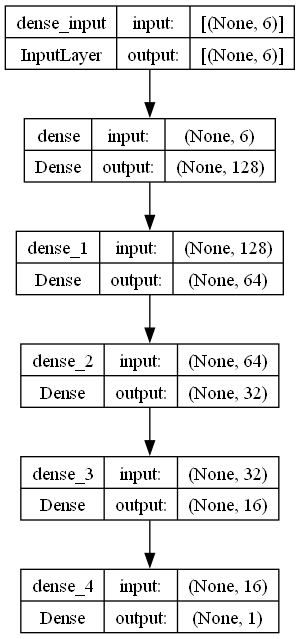

In [28]:
tf.keras.utils.plot_model(model, to_file='fully_connected.png', show_shapes=True, show_layer_names=True)

<a name='3.3'></a>
<h2>&sect;3.3: Keuzes voor het model</h2>

Om een fully connected neuraal netwerk te maken is het belangrijk om de lagen zo op te stellen dat iedere laag een veelvoud is van 2. Ook kan het goed werken om in de eerst volgende laag de helft van de waarde van de laag erboven te pakken. Daarom hebben wij er voor gekozen om het aantal lagen met het aantal neuronen te pakken. Door de vier "Hidden layers" geven we het model tijd om goede keuzes te maken. 

Voor iedere laag gebruiken we de ReLU functie, de Rectified Linear Unit. Wat de ReLU functie doet is, hij maakt iedere input positief. Wanneer een input positief is, blijft deze positief. Wanneer een input negatief is wordt deze 0. Er is iets bijzonders aan de ReLU functie, want hij doet zich eigenlijk voor als een lineaire functie, maar in werkelijheid is dit niet zo. Reden dat we hebben gekozen voor dit model zijn dan ook dat het inputs naar 0 brengt in tegenstelling tot de sigmoid functie die inputs rond de 0 kan brengen. Ook is een neuraal netwerk vaak beter te optimaliseren wanneer er sprake is van lineairiteit. Een neuraal netwerk wordt gebruikt voor complexe vraagstukken, dus vaak ontbreekt er lineairiteit in de data. De ReLU functie kan er voor zorgen dat deze dicht naar lineair gaan. Als laatste is het ook de meest efficiënte functie, omdat het een duidelijke threshold heeft. Hierdoor kan het model ook vaak sneller worden getraind. (Brownlee, 2020)

Om uiteindelijk het model te moeten trainen is het belangrijk dat er een waarde wordt gekozen voor het aantal epochs om het model voor te laten runnen. Wij hebben er voor gekozen om te beginnen bij 1000000000 epochs. Op deze manier kunnen we kijken naar de verandering van de losses om te kijken of er in de laatste paar epochs nog veel verandering is. Door het toepassen van early stopping wordt het duidelijk bij welke epoch het model het beste presteert.

<a name='3.4'></a>
<h2>&sect;3.4: Loss function en optimizer kiezen</h2>

Buiten het opstellen van het aantal lagen, aantal neuronen, activatie functies en het aantal epochs is het ook belangrijk om uit te zoeken welke loss functie en optimizer het best gebruikt kan worden voor ons model.

- Loss function: Als eerst bedenken we welke loss het beste te gebruiken is. Eerst kijken we naar de opdracht, wat moest er ook alweer als resultaat uit het model komen? De opdracht is het voorspellen van huisprijzen van verschillende huizen in Amerika, gebasseerd op gegevens als het aantal badkamers, de ligging, de grootte van het huis, etc. Je zou kunnen zeggen dat het belangrijk is om te kunnen zeggen hoe groot de afstand is tussen de werkelijke waarden en de voorspelde waarden door naar de mean absolute error te kijken, maar dat is in dit geval niet de beste optie. Er staan veel huizen in de dataset en ook veel verschillende prijzen. Er zijn huizen van een paar ton, maar ook van een paar miljoen. Het verschil hierin is zo groot dat de mean absolute error geen goede maatstaaf is. Het is namelijk voor een huis van een ton veel erger om er 50.000 van af te zitten dan een huis van een miljoen. Daarom kiezen wij ervoor om de loss "mean absolute percentage error" te gebruiken. Zo kunnen we alsnog zien hoe veel de voorspelde waardes van de werkelijke waardes afliggen, maar wordt dit weergegeven in percentages. Op deze manier heb je de factor, die zo'n groot verschil in de waardes kon geven, weggehaald.

- Optimizer: Buiten het bepalen van de loss functie is het ook belangrijk om te bepalen welke optimizer er wordt gebruikt om het model te compilen. Wij hebben er voor gekozen om de Adam optimizer te gebruiken, ook wel de Adaptive moment estimator. Adam is een uitgebreidere versie van SGD die efficiënt werkt en ook een stuk sneller is. Ook werkt Adam goed met ruis in de data. Omdat wij veel uitschieters hebben in onze data, zoals de dure huizen met een klein oppervlakte en de goedkope huizen met een groot oppervlakte, kiezen wij ervoor om Adam te gebruiken. (Online, 2023)
    - Werking Adam: Tijdens het trainen houdt Adam twee momenten van de gradiënt bij. Als eerst houdt hij, net als de SGD optimizer, het gemiddelde van de gradiënten bij. Daarnaast houdt hij ook het gemiddelde van de kwadraten van de gradiënten bij. Dit is dus een extra stap die de SGD optimizer niet kent. Ook past Adam verschillende leersnelheden toe aan elk gewicht op basis van de hierboven genoemde momenten. Daarnaast gebruikt Adam informatie over hoe de loss functie verandert ten opzichte van de verschillende parameters van het model om te beslissen welke kant hij op moet gaan om de fout te verkleinen. Het past de grootte van de stapjes aan op basis van hoe groot de gradiënt is, en past ook de richting aan om de beste weg naar beneden te vinden. Op deze manier kan Adam snel en slim leren om het model te verbeteren.

<a name='3.5'></a>
<h2>&sect;3.5: Het model compilen</h2>

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                         loss="mean_absolute_percentage_error")

In [30]:
stop_early = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=1000000000, validation_split=0.2, batch_size=20,
                    callbacks=[stop_early])

Epoch 1/1000000000


16/16 [==============================] - 2s 11ms/step - loss: 99.8728 - val_loss: 99.7406
Epoch 2/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 99.5333 - val_loss: 99.2069
Epoch 3/1000000000
16/16 [==============================] - 0s 5ms/step - loss: 98.6913 - val_loss: 97.8826
Epoch 4/1000000000
16/16 [==============================] - 0s 5ms/step - loss: 96.6164 - val_loss: 94.6313
Epoch 5/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 91.6402 - val_loss: 87.1538
Epoch 6/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 81.3145 - val_loss: 72.2391
Epoch 7/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 65.5678 - val_loss: 60.3153
Epoch 8/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 58.5886 - val_loss: 57.8589
Epoch 9/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 57.6661 - val_loss: 57.4387
Epoch 10/1000000000
16/16 [===================

<a name='3.6'></a>
<h2>&sect;3.6: Visualisatie Loss </h2>

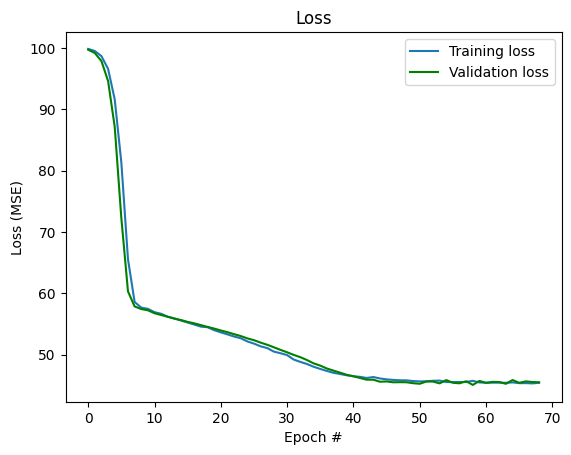

In [31]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss')
plt.legend()
plt.show()

Na het trainen van het model en het plotten van de losses zien we dat er geen sprake is van overfitting, omdat de lijnen van de loss en de validation loss niet ver uit elkaar liggen. Wel valt het op dat de loss waardes vanaf ongeveer epoch 40 niet echt meer veranderen. We hebben geprobeerd met meerdere lagen te werken in ons model, andere aantal neuronen toe te passen, de optimizer aan te passen, maar alle methodes resulteren in de zelfde uitkomst. Ons fully-dense neuraal netwerk komt niet onder de 45% verschil met de werkelijke prijzen. Ook komen wij terug op onze keuze voor het aantal epochs. In het model is early stopping toegepast wat een model stopt, wanneer de loss niet veel meer verandert. Ons model is gestopt bij epoch 64 met een patience van 10 bij de early stopping. Hier stopt het model als de validation loss 10 keer achter elkaar niet meer daalt. 

In [32]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 50.9625


50.96247100830078

Om te kijken hoe gaat het model werkt op de testdata berekeken we ook hiervoor de loss en hier komen we uit op een loss van ongeveer 51% verschil met de werkelijke prijzen van de huizen. Aangezien er een hoop uitschieters waren, en de data niet heel veel correlerende kolommen had, zijn deze resultaten toch al redelijk goed voor ons eerste model.

[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Convolutioneel neuraal netwerk</strong></h2>
</div>

<a name='4.1'></a>
<h2>&sect;4.1: Image-datapipeline </h2>

In [33]:
def image_load(img_dir):
  img_directory = img_dir

  image_size = (1024, 1024)
  batch_size = 4
  image_dataset = tf.keras.utils.image_dataset_from_directory(
      img_directory,
      label_mode=None, 
      image_size=image_size,
      batch_size=batch_size
  )
  return image_dataset

def image_labels(image_dataset,csv):
  image_file_paths = image_dataset.file_paths
  train = pd.read_csv(csv)


  image_hids = [Path(image_file_path).stem for image_file_path in image_file_paths]
  image_hids_int = [int(house_id) for house_id in image_hids]

  labels = [train.loc[train['House ID'] == houseid, 'Price'].values for houseid in image_hids_int]

  labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

  final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))
  return final_dataset

def preprocess_img(final_dataset,choose=2):
  test= choose
  img_height, img_width = 256, 256  
  if test == 1:
    final_dataset = final_dataset.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))
    num_samples = sum(1 for _ in final_dataset)
    val_size = int(0.2 * num_samples) 

    val_dataset = final_dataset.take(val_size)
    train_dataset = final_dataset.skip(val_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return train_dataset, val_dataset
  elif test == 0:
    final_dataset = final_dataset.map(lambda x: (tf.image.resize(x, (img_height, img_width))))
    return final_dataset
  else:
    return print('Please choose 1 for train and 0 for test')

In [34]:
Images_labeled= image_labels(image_load('Train'),'train.csv')
train_dataset, val_dataset = preprocess_img(Images_labeled, choose = 1)

Found 500 files belonging to 1 classes.


Hierboven hebben we 3 functies gemaakt om onze pipeline te bouwen. Dit bestaat uit de functies: image_load, image_labels en preprocess_img. Bij de eerste functie image_load worden de foto’s ingeladen, dit wordt via batches van 4 gedaan omdat we al snel doorhadden dat bij een hoger getal onze computers het opgaven omdat het te veel werkgeheugen in beslag nam. De tweede functie image_labels voegt de correcte prijs labels aan de correcte foto. De derde functie preprocess_img heeft twee opties, bij allebei de opties worden de foto’s gerescaled naar de dimensie 256 bij 256. Dit wordt gedaan om het nog wat minder zwaar te maken voor onze computers. De eerste optie wordt gebruikt voor de trainset waarbij naast het rescalen ook nog de dataset in een AUTOTUNE gestopt om het data in laden voor het model te optimaliseren. De tweede opties is er voor de fotos waarvoor we de prijs willen voorspellen waarbij dus alleen de foto’s worden gerescaled. Wij hebben om 2 redenen de keuze gemaakt om geen data augmentation toe te passen op de foto’s. De eerste reden is dat de hoeveelheid foto’s al redelijk zwaar was voor onze computers en dus via data augmentation zodat nog een stuk erger worden. De tweede reden is omdat we bij andere groepjes al gezien hadden dat de data augmentation niet echt een merkbaar effect had dus omdat dan toe te voegen maar ons model wel veel slomer te maken vonden wij dus niet nodig.  

<a name='4.2'></a>
<h2>&sect;4.2: Hyperparameter tuner </h2>

Hieronder is de code weergegevens van een uitgevoerde hyperparameter tuner. In foto's is de uitkomst gedeeld, omdat het in een ander bestand erg lang heeft moeten runnen. Om dit opnieuw te voorkomen hebben we de code in een Raw NBConvert gezet zodat de code wel beschikbaar is, maar het niet meer hoeft te runnen. De uitkomst van deze hyperparameter tuner is gebruikt om het uiteindelijke model mee te trainen.

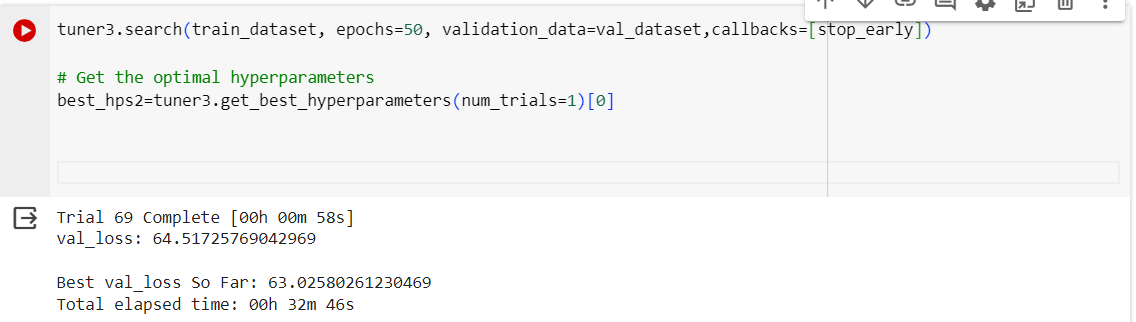

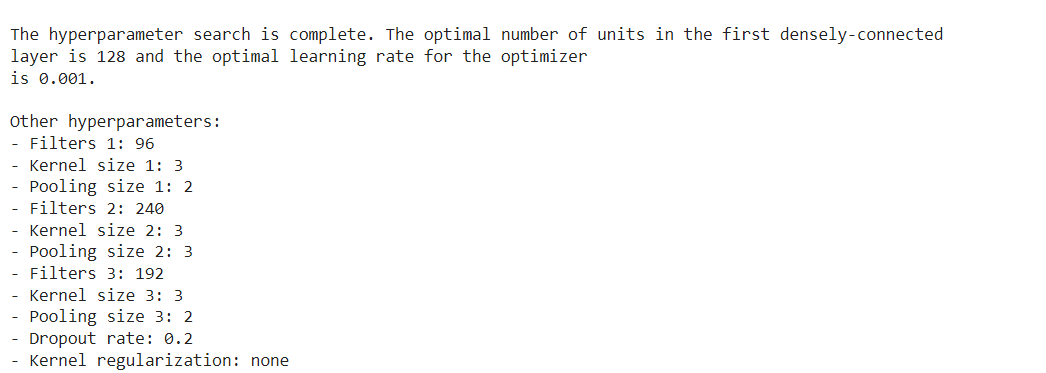

<a name='4.3'></a>
<h2>&sect;4.3: Het model </h2>

In [35]:
normalization_layer = tf.keras.layers.Rescaling(
    scale=1./255, offset=0.0)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)
cnn_model = tf.keras.Sequential([
    keras.Input(shape=((256,256,3))),
    normalization_layer,
    tf.keras.layers.Conv2D(96, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(240, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Conv2D(192, 3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

<a name='4.4'></a>
<h2>&sect;4.4: Modelarchitectuur</h2>

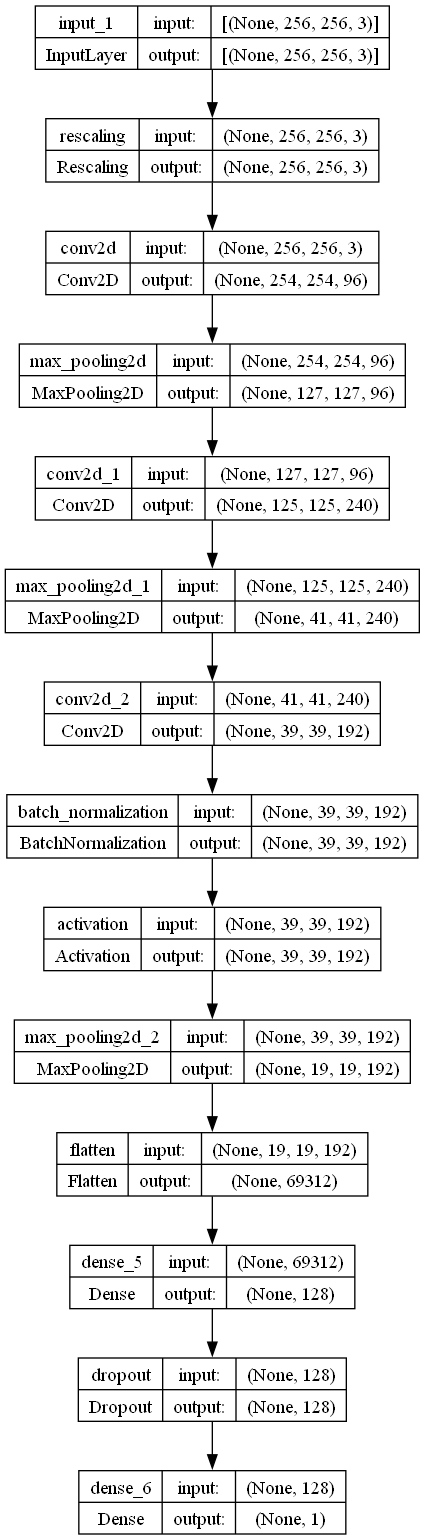

In [36]:
tf.keras.utils.plot_model(cnn_model, to_file='jemoeder.png', show_shapes=True, show_layer_names=True)

<a name='4.5'></a>
<h2>&sect;4.5: Uitleg Model</h2>

Wij hebben ons best gedaan om een dergelijk hetzelfde soort onderzoek te vinden met een model architectuur, helaas is dit ons niet gelukt. Daarom hebben wij gekozen voor een model architectuur die wij veel al bij de les gebruikt hebben en die ook in de les het goed deed bij image analysis. Zoals je hierboven/onder kan zien bestaat het model uit 12 layers. Deze layers bestaan uit een input layer, een normalisatie layer, 3 maal een convolution layer, 3 maal een maxpooling layer , een flatten layer en ten slotte nog 2 dense layers waar bij de tweede dense layer ook dient als output layer. Alle hyperparameters hebben we bepaald doormiddel van een hyperband tuner behalve de laatste dense layer waarbij de aantal units 1 is omdat dit een regressie probleem is. Wij hebben voor dezelfde redenen als bij het Fully-Connected Neural Network overal de activatie van ReLu gebruikt. 

#### Input Layer:
Dit is de layer waarbij de data ingeladen wordt, we hebben hiervoor de data al naar een nieuwe schaal gebracht zodat de benodigde rekenkracht niet te zwaar werd voor onze computers. In de input layer hebben we de nieuwe correcte ‘shape’ gegeven van de data namelijk (256,256,3). Hierbij staan de 2 maal 256 voor de hoogte en breedte van de data en de 3 voor de kleuren (RGB). 

#### Normalisation Layer:
De Normalisation layer bestaat eigenlijk uit een andere layer, namelijk de Rescaling Layer. Deze layer schaalt de waardes naar een nieuw bereik. De waardes gaan hier van een bereik van [0, 255] naar een bereik van [0, 1], dit wordt aan gegeven door de parameter ‘scale=1./255’. (Chollet, F., & others., 2015.)

#### Convolutional Layer:
De convolution layer is de layer die een CNN een CNN maakt. Het is een layer die een convolutie uit op de gegevens, dit zijn meestal afbeeldingen. De layer past een set van filters uit op de gegevens. Deze filters zijn matrices die langzaam over de matrices van de foto’s worden geschoven. Hiermee proberen de filters kenmerken van de foto’s te herkennen. De hoeveelheid filters wordt in de layer bepaald door het eerste getal, in dit model zijn dit de getallen 96, 240 en 192 en ze zijn bepaald door een hypertuner. Het tweede getal, in dit geval elke keer 3, bepaald de grote van de matrices van de filters, de matrix is dus 3 bij 3. Het getal 3 is wederom bepaal door een hypertuner. (ChatGPT. 2024. Prompt: Conv2D: Afbeeldingskenmerken extraheren.) 

#### Maxpooling Layer:
De maxpooling layer wordt vaak uitgevoerd na een convolutional layer, deze layer maakt weer een nieuwe matrix waarbij van steeds van een venster van de input matrix het hoogste getal wordt genomen. Hierdoor verklein je de dimensionaliteit van de data. De grote van de vensters wordt bepaald door de getallen in de MaxPooling2D layer, in dit geval dus 2, 3 en weer 2. Deze getallen slaan op de dimensie van de vensters dus 3 is het venster 3 bij 3. Wij hebben de grote van de vensters bepaald door een hypertuner.

#### BatchNormalisation Layer: 
Deze layer normaliseert de waardes in ‘batches’ (subsets van de waardes). Hij brengt hier dan de gemiddelde waardes van de batches dichtbij 0 en de standaarddeviatie dichtbij 1. (Chollet, F., & others., 2015.)
We hebben batchnormalisation toegepast omdat het model eerst overfitten, we hebben dat eerst alleen proberen op te lossen met een dropout layer maar we kwamen er snel achter dat een combinatie van 2 in het model het best werkte. Ook maakt de batchnormalisatie het runnen van het model wat sneller wat goed meegepakt is want door de grote aantal foto’s runt het model niet even snel op iedereens computer. 

#### Activation Layer:
Deze layer werkt hetzelfde als de parameter ‘activation’ die in veel van de andere layers gebruikt wordt. We gebruiken hier de activation pas na de batchnormalisatie omdat die deels al de dingen doet dat ReLu ook zal doen waardoor je als je de activation pas er na doet het model wat sneller zou runnen. 

#### Flatten Layer:
De Flatten layer maakt de data letterlijk plat. Het maakt van een multidimensionale input een 1-dimensionale output. Als je bijvoorbeeld een input shape van (1, 20, 10) hebt bij de flatten layer dan geeft het 1x20x10= 200, nu is de shape dan (200). (Chollet, F., & others., 2015.)

#### Dense Layer:
Een Dense layer is een laag met neuronen waarbij elke neuron verbonden is met elke neuron in de laag ervoor, hierdoor kan de laag complexe patronen in de data herkennen. Het getal 128 in de eerste dense layer staat voor het aantal neuronen in die dense layer. We zijn op dat aantal gekomen doormiddel van een hypertuner. Het getal 1 in de tweede (en laatste) dense layer is ook wel de output layer, dit moet naar 1 neuron omdat je een regressie probleem hebt en dus maar 1 getal terug wil (de prijs). Wij hebben voor de Dense layers een activatie van ‘ReLu’ gebruikt.(Science & Science, 2024)

#### Dropout Layer: 
De Dropout layer verandert willekeurig waardes naar 0 en schaalt daarna de rest van de waardes omhoog door 1/(1-rate) zodat de som van de waardes hetzelfde is. Hierdoor worden dus sommige waardes ‘gedropout’. Dit wordt gedaan om overfitting tegen te gaan, wij hebben ook voor deze reden de dropout layer gebruikt omdat het model eerst was aan het overfitten. De 0.2 in de laag staat voor de ‘rate’ ofwel het percentage van de waardes dat gedropt worden, in dit geval dus 20%. Deze 0.2 is wederom bepaalt door een hypertuner. 

<a name='4.6'></a>
<h2>&sect;4.6: Het model trainen </h2>

In [37]:
opt= keras.optimizers.Adam(learning_rate=0.0001)

cnn_model.compile(optimizer=opt,
              loss='mape')
cnn_history = cnn_model.fit(train_dataset, epochs=1000000, validation_data=val_dataset, callbacks=[stop_early])


Epoch 1/1000000


100/100 [==============================] - 11s 45ms/step - loss: 99.4895 - val_loss: 99.7535
Epoch 2/1000000
100/100 [==============================] - 4s 37ms/step - loss: 97.6734 - val_loss: 98.6053
Epoch 3/1000000
100/100 [==============================] - 4s 40ms/step - loss: 95.1004 - val_loss: 96.0574
Epoch 4/1000000
100/100 [==============================] - 4s 38ms/step - loss: 91.6030 - val_loss: 90.3119
Epoch 5/1000000
100/100 [==============================] - 4s 38ms/step - loss: 87.4179 - val_loss: 88.4604
Epoch 6/1000000
100/100 [==============================] - 4s 38ms/step - loss: 83.0760 - val_loss: 84.4107
Epoch 7/1000000
100/100 [==============================] - 4s 38ms/step - loss: 78.8802 - val_loss: 75.4733
Epoch 8/1000000
100/100 [==============================] - 4s 37ms/step - loss: 75.9869 - val_loss: 68.2892
Epoch 9/1000000
100/100 [==============================] - 4s 36ms/step - loss: 73.6946 - val_loss: 68.5882
Epoch 10/1000000
100/100 [=================

We hebben voor het bepalen van de juiste epochs dezelfde manier gebruikt als bij het Fully-Connected Network, eerst een hele hoge epochs aangegeven en early_stopping toevoegen. Hierdoor zijn we op 35 epochs gekomen.

<a name='4.7'></a>
<h2>&sect;4.7: Loss Visualisatie </h2>

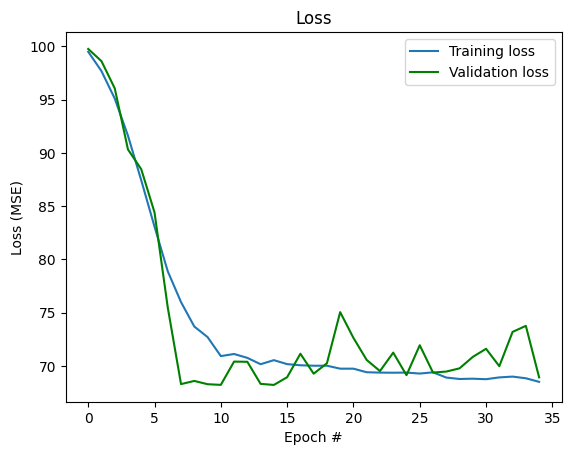

In [38]:
plt.plot(cnn_history.history['loss'], label='Training loss')
plt.plot(cnn_history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss')
plt.legend()
plt.show()

Hier mischien nog wat schrijven?? maar dan moet ik eerst het model uiteindelijk runnen

<a name='4.8'></a>
<h2>&sect;4.8: Predicties en Kaggle </h2>

In [39]:
def to_kaggle(model, predict,naam):
  predictions = model.predict(predict)
  house_id_kaggle= list(range(501, 536))
  data = list(zip(house_id_kaggle, predictions))

  inleveren_kaggle = pd.DataFrame(data, columns=['House ID', 'Price'])

  inleveren_kaggle['Price'] = inleveren_kaggle['Price'].astype(float)

  print(inleveren_kaggle)
  return inleveren_kaggle.to_csv(naam, index=False)

In [41]:
predict_this= preprocess_img(image_load('Test'),0)
to_kaggle(cnn_model, predict_this, 'Cnn_kaggle.csv')

Found 35 files belonging to 1 classes.
5/9 [===============>..............] - ETA: 0s

9/9 [==============================] - 1s 48ms/step
    House ID          Price
0        501  143512.968750
1        502  141404.312500
2        503  146628.531250
3        504  164077.359375
4        505  113652.828125
5        506  153182.656250
6        507  151075.015625
7        508  133283.046875
8        509  145336.187500
9        510  151883.375000
10       511  130824.179688
11       512  157052.625000
12       513  134024.781250
13       514  145002.859375
14       515  127724.992188
15       516  160302.062500
16       517  132382.000000
17       518  135362.437500
18       519  127142.554688
19       520  171430.750000
20       521  171855.953125
21       522  135370.468750
22       523  162769.218750
23       524  144967.156250
24       525  153219.656250
25       526  158513.968750
26       527   87544.789062
27       528  177240.843750
28       529  169997.562500
29       530  158764.250000
30       531  142336.765625
31       532  134791.875000
32       533  170858.906

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Transfer Learning</strong></h2>
</div>

<a name='5.1'></a>
<h2>&sect;5.1: Het model</h2>

In [42]:
#ChatGPT, 2024. Prompt 1: Transfer model layout
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
stop_early = EarlyStopping(monitor='val_loss', patience=5)

for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1)(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

<a name='5.2'></a>
<h2>&sect;5.2: Modelarchitectuur</h2>

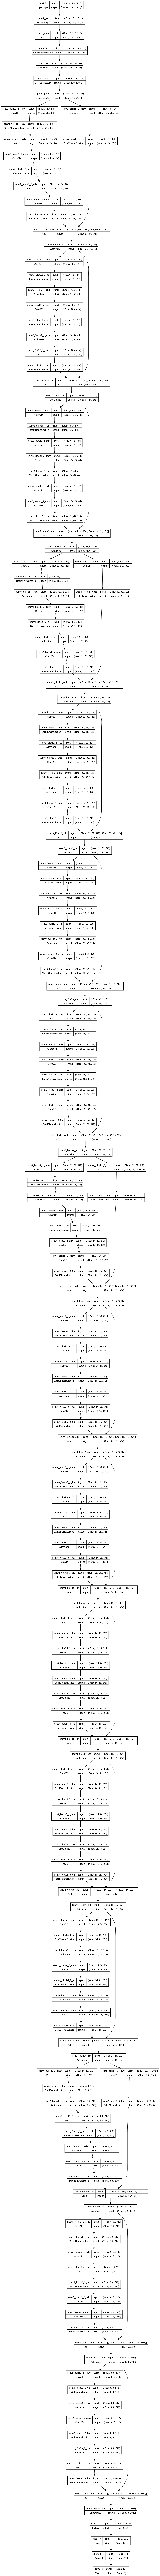

In [43]:
tf.keras.utils.plot_model(transfer_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<a name='5.3'></a>
<h2>&sect;5.3: Het model trainen</h2>

In [44]:
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mape')
history = transfer_model.fit(train_dataset, epochs=100, validation_data=val_dataset, 
                              callbacks=[stop_early])

Epoch 1/100


100/100 [==============================] - 5s 33ms/step - loss: 95.9232 - val_loss: 91.9426
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 86.8174 - val_loss: 83.2511
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - loss: 81.3949 - val_loss: 80.6296
Epoch 4/100
100/100 [==============================] - 3s 27ms/step - loss: 79.7575 - val_loss: 79.2581
Epoch 5/100
100/100 [==============================] - 3s 27ms/step - loss: 78.4132 - val_loss: 78.6882
Epoch 6/100
100/100 [==============================] - 3s 27ms/step - loss: 77.3621 - val_loss: 77.7176
Epoch 7/100
100/100 [==============================] - 3s 26ms/step - loss: 76.7421 - val_loss: 77.1753
Epoch 8/100
100/100 [==============================] - 3s 26ms/step - loss: 76.4706 - val_loss: 76.9108
Epoch 9/100
100/100 [==============================] - 3s 26ms/step - loss: 75.7401 - val_loss: 76.5828
Epoch 10/100
100/100 [==============================] - 3s 26ms/step - loss:

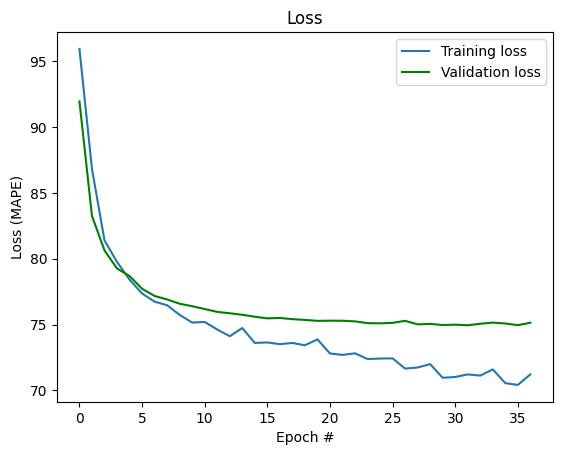

In [45]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss')
plt.legend()
plt.show()

Het valt op dat het model niet overfit, maar toch geen super goede loss laat zien. Dit was al te verwachten, omdat we gebruik maken van een transfer learning model. Dit model is vooraf getraind op foto data in categoriën. Het model is dus erg goed in het voorspellen van classificatie data, maar ons probleem is een regressie probleem. Er waren dan ook geen verwachtingen van een super lage loss.

In [46]:
stop_early1 = EarlyStopping(monitor='val_loss', patience=5)
fine_tune_at = 80

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

base_learning_rate2 = 0.0001

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate2)
, loss="mape")

fine_tune_epochs = 10
total_epochs = 50 + fine_tune_epochs

history_fine = transfer_model.fit(train_dataset,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=val_dataset,
                             callbacks=[stop_early1]
                             )

Epoch 37/60


100/100 [==============================] - 6s 34ms/step - loss: 69.8015 - val_loss: 74.8904
Epoch 38/60
100/100 [==============================] - 3s 28ms/step - loss: 69.7029 - val_loss: 74.8389
Epoch 39/60
100/100 [==============================] - 3s 28ms/step - loss: 69.4761 - val_loss: 74.8019
Epoch 40/60
100/100 [==============================] - 3s 28ms/step - loss: 69.4578 - val_loss: 74.7954
Epoch 41/60
100/100 [==============================] - 3s 28ms/step - loss: 69.9865 - val_loss: 74.7937
Epoch 42/60
100/100 [==============================] - 3s 27ms/step - loss: 69.1826 - val_loss: 74.7656
Epoch 43/60
100/100 [==============================] - 3s 27ms/step - loss: 68.5848 - val_loss: 74.7229
Epoch 44/60
100/100 [==============================] - 3s 27ms/step - loss: 69.7996 - val_loss: 74.6944
Epoch 45/60
100/100 [==============================] - 3s 27ms/step - loss: 69.3105 - val_loss: 74.6666
Epoch 46/60
100/100 [==============================] - 3s 27ms/step - loss: 

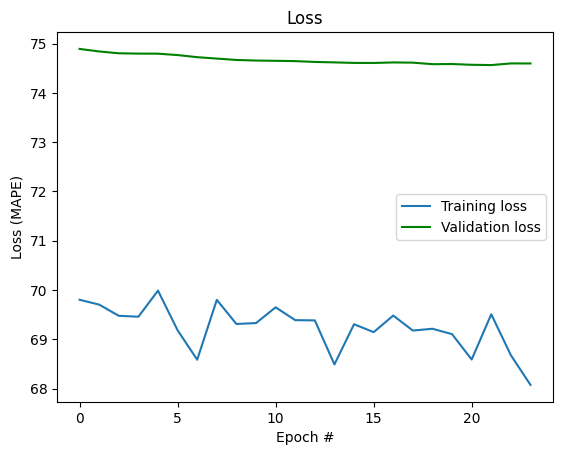

In [47]:
plt.plot(history_fine.history['loss'], label='Training loss')
plt.plot(history_fine.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss')
plt.legend()
plt.show()

<a name='5.4'></a>
<h2>&sect;5.4: Naam van de modelarchitectuur en de dataset</h2>

Voor transfer learning hebben we er voor gekozen om een ResNet50 model te gebruiken. Dit model gebruikt 50 lagen in het originele model, wat kan helpen bij het voorspellen van huisprijzen gebasseerd op foto's van de binnenkant van het huis. Het heeft namelijk enorm veel lagen waaruit het model patronen kan herkennen. De reden dat wij daarom dan ook dit model gebruiken is om het origineel is getraind met de "imagenet" dataset. Dit is een dataset met meer dan 14 miljoen foto's die verdeeld zijn onder meer dan 1000 verschillende categoriën. Het is dus erg goed in het onderverdelen van foto's in categoriën, wat wil zeggen dat een transfer learning model vooral goed werkt voor classificatie problemen. Aangezien de opdracht voor deep learning gaat om een regressie probleem is het belangrijk om een model te kiezen die goed werk en veel lagen gebruikt, zodat het model alsnog zijn tijd krijgt om de patronen van de data te leren.

Kundu (2023)

<a name='5.5'></a>
<h2>&sect;5.5: Voordelen vooraf getrainde visionmodellen</h2>

Er zijn een aantal voordelen voor het gebruiken van een vooraf getraind model, ook wel transfer learning model. Een aantal voordelen zijn:

- Flexibel: Een van de voordelen van het gebruiken van een transfer learning model is de flexibiliteit. Een model is getraind op een bestaande dataset, maar kan zelf zo worden aangepast dat het voor jouw specifieke probleem een goed werkend model kan worden. Je kan het dus voor veel verschillende soorten vraagstukken gebruiken. 
- Efficiëntie: Wanneer een vooraf getraind model wordt gebruikt als ingangspunt van een model kan het een hoop tijd en rekenkracht besparen. Zo is het model al een keer getraind en hoeft het niet, als andere modellen, vanaf het begin te beginnen. Dit zorgt er voor dat het model een stuk minder kracht nodig heeft en vaak opnieuw getraind en getest kan worden, wat bij andere modellen juist heel erg veel tijd kan kosten.
- Grote van de dataset: Een ander belangrijk voordeel voor het gebruiken van een transfer model is de grote die het model nodig heeft om goede voorspellingen te kunnen doen. Het is bij de meeste neurale netwerken nodig om je model te trainen met enorm veel data, zodat het model de complexere  patronen kan herkennen in de data. Bij een transfer model is dat niet per se nodig, omdat het model natuurlijk al eerder is getraind. Het kan patronen snel herkennen en hiervoor zijn geen bakken aan data voor nodig. Wanneer je dus een neuraal netwerk wilt opstellen, maar je hebt niet super veel foto data beschikbaar kan het handig zijn om te beginnen met een transfer model. Dit model kan hier namelijk het beste mee om gaan.
- Kosten: Als laatste voordeel is het ook belangrijk te benoemen dat het model dus ook echt veel geld kan besparen. Zo is het niet nodig om heel erg veel data te verzamelen om patronen te kunnen herkennen. Het scheelt zo tijd en dus ook geld, maar daarbuiten zijn er nog meer redenen waarom het geld kan besparen. Zo heeft het een stuk minder rekenkracht nodig dan andere modellen, waardoor het voor de meeste computers en laptops makkelijk te gebruiken is. Dit voordeel is vooral erg voordelig voor mensen die een klein bedrijf hebben opgezet en bijvoorbeeld nog niet genoeg geld hebben om de duurste en krachtigste computers te kopen. 

What Is Transfer Learning (2024)

<a name='5.6'></a>
<h2>&sect;5.6: Stappen finetunen vooraf getraind model en motivatie keuzes</h2>

Om het model te finetunen zijn er een aantal stappen doorlopen:
1. Als aller eerst wordt er een transfer learning model uitgekozen. Wij hebben er voor gekozen om een ResNet50 model te trainen. Dit is een vooraf getraind model en heeft dus al een hele hoop lagen van zichzelf, maar toch kunnen we er zelf ook nog wat lagen aan toevoegen. Het model is getraind op de "ImageNet" dataset waar meer dan 14 miljoen foto's in staan.
2. Alle gewichten van de lagen van het vooraf getrainde model worden uitgezet, zodat we het model de mogelijkheid geven om te leren van de nieuwe data, zonder de gewichten die toegevoegd zijn aan het transfer learning model.
3. De lagen die zijn toegevoegd aan het model zijn:
    - Flatten: Maakt van een 3D uitput een 1D input voor de volgende laag.
    - Dense laag van 128 neuronen en een l2 regularisatie van 0.001: Er is regularisatie toegepast om overfitting te voorkomen. Er wordt gekozen voor een l2 regularisatie, omdat alle parameters belangrijk zijn en we dus geen belangrijke informatie missen tijdens het trainen van het model.
    - Dropout van 50%: Een willekeurige "batch" van 50% van de neuronen wordt uitgeschakeld tijdens het trainen. Er wordt gekozen voor een dropout van 0.5, want het kan helpen tegen overfitting. De dropout van 0.5 is er perfect balans tussen het tegen gaan van overfitting, maar niet te veel data verliezen.
    - Dense laag van 1 neuron die de voorspellingen doet. We doen dit, omdat we te maken hebben met een regressie probleem. Dit wilt zeggen dat er allemaal verschillende uitkomsten kunnen zijn die niet gekoppeld zijn aan een categorie. 
4. Het model wordt aangemaakt door de functie "Model" van tf.keras.model waar de input het ResNet50 model bevat en de output de voorspellingen zijn die worden gemaakt in de laatste toegevoegde laag "predictions".
5. Hierna wordt het tijd om het model te gaan compileren. We kiezen er voor om Adam te gebruiken als optimizer met een learning rate van 0.001. Om het model te evalueren maakt het model gebruik van de loss "mean absolute percentage error". Dit doen we, omdat het een loss functie is die de loss kan berekenen voor een groot bereik. Zo zijn er huizen van een paar ton, maar ook een paar miljoen. Het is dus belangrijk om te weten hoe groot het percentage is van de fouten.
6. Na het compileren van het model is het tijd om het model te trainen. De dataset "train_dataset" wordt gebruikt om het model te trainen. Om te kijken hoe goed het model presteert op nog niet geziene data wordt er ook een "val_dataset" toegevoegd. Dit wordt ook weergegeven tijdens de uitkomst van het trainen. Hier wordt de loss en val_loss gegeven. Het model wordt getraind met 100 epochs en een early stopping van een patience van 5. Zo zorgen we er voor dat we het model de ruimte geven om door te trainen totdat de val_loss 5 keer achter elkaar niet meer lager wordt.
7. Na het trainen van het model zien we de losses en die worden weergegeven in een visualisatie om te kijken of er geen overfitting plaats vindt. Als de loss en val_loss ver uit elkaar lopen is er sprake van overfitting, maar bij de visualisatie van ons transfer learning model zie je de lijnen mooi naar elkaar toelopen. Dit laat zien dat er zeker geen sprake is van overfitting.
8. Nu zijn we aangekomen bij het finetunen van het model. We doen dit, omdat we willen kijken of het model beter presteert wanneer het de data al eens heeft gezien en we nu gewichten toevoegen na ongeveer de helft van de lagen van het model.
9. We maken eerst een nieuwe early stopping aan met een patience van 10. Hier geven we het model iets meer ruimte om te zoeken naar de juiste epoch. Zo stopt het model nu pas wanneer de val_loss 10 keer achter elkaar niet meer naar beneden gaat.
10. Om het model te finetunen hebben we gekozen voor een threshold vanaf waar het model wel de gewichten van de lagen aanzet. Wij hebben er voor gekozen om dit vanaf laag 80 te doen. Het model wat gebruikt wordt heeft 175 lagen, dus wanneer we de threshold op 80 zetten heeft het model nog 95 lagen waar de gewichten wel van worden bekeken. 
11. Ook gebruiken we een andere, kleinere, learning rate. Zo gaat het model in kleinere stapjes opzoek naar het global minima. Hier zal de mean absolute percentage error loss het laagste, en dus beste, zijn.
12. Na het nemen van deze fine tune stappen compileren en trainen we het model opnieuw, met 60 epochs totaal, omdat het model was gestopt rond de 40 waar de score niet veel meer verschilden. We kijken of er na ongeveer 20 stappen nog iets veranderd in de voorspellingen.
13. Als laatste laten we opnieuw de grafiek zien van de loss en de val_loss. We zien hier eigenlijk een stuk slechtere prestaties. Er zijn veel schommelingen en het model traint niet mooi verder vanaf de laatste epoch van het getrainde model. Daarom gebruiken wij het model liever voor het finetunen, omdat dit voor ons de meest betrouwbare resultaten levert. Wel is het belangrijk om te melden dat de schommelingen van het gefinetunde model niet zo dramatisch zijn, want de stapjes op de y-as zijn erg klein. Hierdoor liggen de waardes van de loss en val_loss alsnog dicht bij elkaar, maar toch schommelen de waardes te veel om ze als betrouwbaar te zien.

<a name='5.7'></a>
<h2>&sect;5.7: Predicties en Kaggle</h2>

In [48]:
to_kaggle(transfer_model, predict_this, 'Transfer_kaggle.csv')

9/9 [==============================] - 1s 28ms/step
    House ID          Price
0        501  124617.468750
1        502   94464.085938
2        503  133312.984375
3        504  138275.265625
4        505  143244.312500
5        506  110972.921875
6        507  148794.781250
7        508  159217.812500
8        509  108984.703125
9        510  126613.593750
10       511  134285.890625
11       512  141744.218750
12       513  147189.187500
13       514  128632.460938
14       515  101950.390625
15       516  173740.531250
16       517  129404.914062
17       518  109311.515625
18       519  148776.312500
19       520  121352.750000
20       521  149860.625000
21       522  137915.968750
22       523  132439.093750
23       524  110338.890625
24       525  129919.515625
25       526  157765.500000
26       527  117732.328125
27       528  118140.445312
28       529  124271.312500
29       530  124980.578125
30       531   99310.960938
31       532  110057.679688
32       533  127712.828

[Back to the top](#start)
<a name='6.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Multimodaal model</strong></h2>
</div>

In [49]:
img_height, img_width = 1024, 1024

In [50]:
from pathlib import Path
import tensorflow as tf

# Update the image directory path
img_directory = "Train"

# Load images without considering the directory-generated labels
image_size = (1024, 1024)
batch_size = 32

# This loads the images but ignores the labels
image_dataset = tf.keras.utils.image_dataset_from_directory(
    img_directory,
    label_mode=None,  # Ignore directory-based labels
    image_size=image_size,
    batch_size=batch_size
)

# Extract file paths from the dataset
image_file_paths = image_dataset.file_paths

# Extract only file ID without extension from file paths
image_hids = [Path(image_file_path).stem for image_file_path in image_file_paths]
image_hids = [int(hid) for hid in image_hids]

tabular_data = [train.loc[train['House ID'] == houseid, ['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude']].values[0] for houseid in image_hids]

# Convert the list of tabular data into a TensorFlow dataset
tabular_dataset = tf.data.Dataset.from_tensor_slices(tabular_data).batch(batch_size)

# Combine the original image dataset with the tabular dataset

labels = [train.loc[train['House ID'] == houseid, 'Price'].values[0] for houseid in image_hids]

# Convert the list of labels into a TensorFlow dataset
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

# Combine the original image dataset with the labels dataset
combined_dataset = tf.data.Dataset.zip((image_dataset, tabular_dataset, labels_dataset))

Found 500 files belonging to 1 classes.


In [51]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from keras.models import Model

# Define the image input
image_input = Input(shape=(img_height, img_width, 3), name = 'image_input')

# Define the numerical input
numerical_input = Input(shape=(5,), name='numerical_input')
x = Dense(64, activation='relu')(numerical_input)
x = Dense(32, activation='relu')(x)


# Convolutional layers for image input
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool2)

# Concatenate the flattened image features with the numerical input
concatenated = concatenate([x, flatten])

# Dense layers for the concatenated input
dense1 = Dense(64, activation='relu')(concatenated)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=[image_input, numerical_input], outputs=output)


In [52]:
epochs = 10
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_3 (Conv2D)              (None, 1022, 1022,   896         ['image_input[0][0]']            
                                32)                                                               
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 511, 511, 32  0          ['conv2d_3[0][0]']               
                                )                                                           

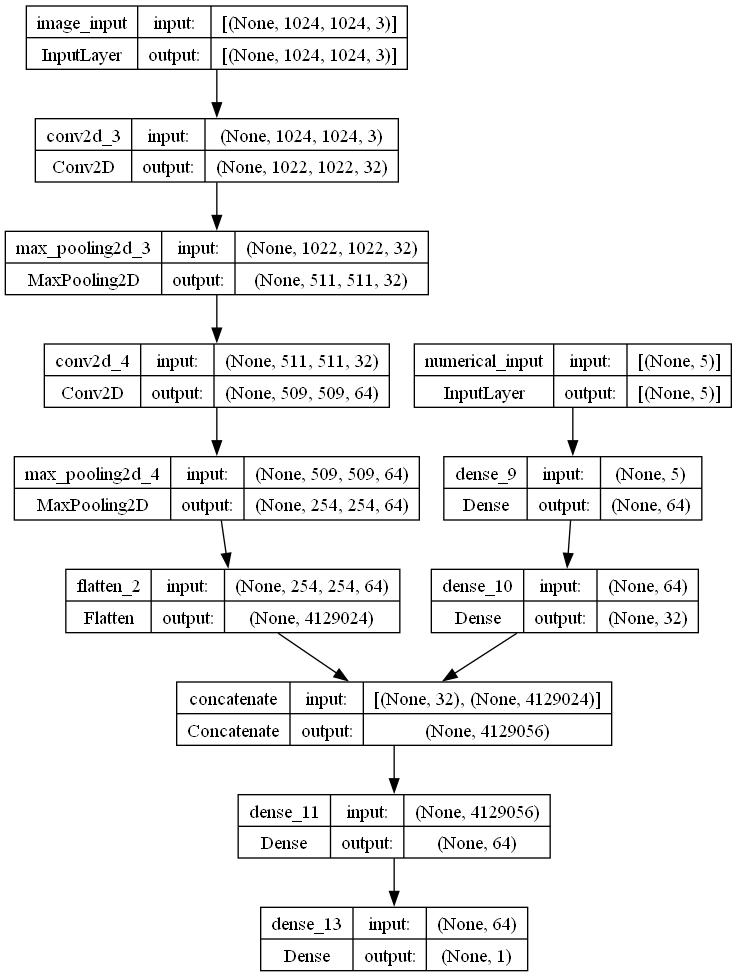

In [53]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
val_dataset = combined_dataset.skip(25)

In [66]:
combined_dataset

<ZipDataset element_spec=(TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=3)

epochs = 10
history = model.fit(x=[final_dataset, train_dataset],validation_data=val_dataset, epochs=epochs, callbacks=[early_stopping], verbose=1)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'tensorflow.python.data.ops.dataset_ops.ZipDataset'>", "<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>"}), <class 'NoneType'>

[Back to the top](#start)
<a name='7.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H7: Bevindingen</strong></h2>
</div>

<a name='7.1'></a>
<h2>&sect;7.1: Samenvatting uitkomsten</h2>

##### Geef een beknopt overzicht van de resultaten

##### Welk model presteert het beste? Met welke parameters?

##### Toon je scores op Kaggle en laat zien wat de resultaten waren van je verbeteringen op Kaggle.

[Back to the top](#start)
<a name='8.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H8: Conslusie en aanbevelingen</strong></h2>
</div>

<a name='8.1'></a>
<h2>&sect;8.1: Uitdagingen modelleringsproces</h2>

<a name='8.2'></a>
<h2>&sect;8.2: Prestaties modelarchitecturen</h2>

<a name='8.3'></a>
<h2>&sect;8.3: Advies aan makelaar</h2>

<a name='8.4'></a>
<h2>&sect;8.4: Advies huizen(ver)koper</h2>

[Back to the top](#start)
<a name='9.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H9: Literatuurlijst</strong></h2>
</div>

Fully dense neural network:
- Brownlee, J. (2020, 20 augustus). A Gentle Introduction to the Rectified Linear Unit (ReLU). MachineLearningMastery.com. https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
- Online, S. (2023, 16 november). Adam Optimizer for Stochastic Gradient Descent - Shiksha Online. Shiksha.com. https://www.shiksha.com/online-courses/articles/adam-optimizer-for-stochastic-gradient-descent/#What-is-Adam-Optimizer?-

CNN model:
- Chollet, F., & others. (2015). Keras documentation: Rescaling layer. https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
- ChatGPT. (2024). Prompt: Conv2D: Afbeeldingskenmerken extraheren. 
https://chat.openai.com/share/c4a56f6d-e022-4d9f-b333-3594b697dec9 
- Chollet, F., & others. (2015). Keras documentation: Batch Normalization layer. https://keras.io/api/layers/normalization_layers/batch_normalization/
- Chollet, F., & others. (2015). Keras documentation: Flatten layer. 
https://keras.io/api/layers/reshaping_layers/flatten/
- Science, B. O. C., & Science, B. O. C. (2024, 18 maart). The Concepts of Dense and Sparse in the Context of Neural Networks | Baeldung on Computer Science. Baeldung On Computer Science. https://www.baeldung.com/cs/neural-networks-dense-sparse#:~:text=A%20dense%20layer%20is%20a,neurons%20in%20the%20previous%20layer.

Transfer learning model:
- ChatGPT. (2024). Promt 1: Transfer model layout. https://chat.openai.com/share/5044a49e-c89d-41f9-b7aa-8faf5366704d
- What is Transfer Learning. (2024, 16 januari). Deepchecks. https://deepchecks.com/glossary/transfer-learning/
- Kundu, N. (2023, 23 januari). Exploring ResNet50: An In-Depth Look at the Model Architecture and Code Implementation. Medium. https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f